In [1]:
import sys

In [2]:
import numpy as np
from myimgtools import *
from mymath import *
from PDHGtools import *

# Optimization problem:                                                      
$$ min_{u\in \Delta}  \underbrace{0.5|Au-b|_2^2}_{G} + \underbrace{\mu|Ku|_{2,1}}_{f},$$
 where $\Delta = \{u\vert 0\leq u \leq 255\}$

                                                                            

# Sadle problem
 $$\min_u\max_{p}<Ku,P>+g(u) + G(u)-f^*(p) - F(p),$$
 where $g = I_{\Delta}$ and $F\equiv 0$
### Inclusion problem
 $$T(z)+ Bz\ni 0,$$
where $z=\begin{pmatrix}u\\p\end{pmatrix}$, $T:=\begin{pmatrix} \partial I_{\Delta} &+K^*\\-K&\partial f^*(.)\end{pmatrix}$, $B:=\begin{pmatrix} A^T(Au-b) \\0\end{pmatrix}$ and $B$ is lipschitz and co-coercive.

Let us consider using PDHG method with variable metric  identity $I$ plus lower rank matrix $Q=UU^T$ multiplied by $M$
$$(M+Q)(z_{k+1}-z_{k})+T(z_{k+1})\ni -Bz_k,$$
where $M$ is defined as following:
$$M=\begin{pmatrix}I/\tau&-K^*\\-K&I/\sigma\end{pmatrix}$$

### Load image

In [72]:
filename = "Diana240";
img = mpimg.imread("data/" + filename + ".png"); 
img = rgb2gray(img);
(ny,nx) = np.shape(img);
print ("image dimensions: ", np.shape(img))

image dimensions:  (240, 240)


### Construct blur kernel

In [4]:
k = 10;
s = 2*k+1;
filter = np.zeros((s,s));

### Construct Gaussian kernel


In [5]:
if False:   
    sigma = 25;
    [dx,dy] = np.meshgrid(np.linspace(-k,k,s), np.linspace(-k,k,s));
    filter = np.exp(-(dx**2+dy**2)/(2.0*sigma**2));
    filter = filter/np.sum(filter);
    print(filter)
    plt.imshow(filter);
    plt.show()

### Read filter from image

In [6]:
if True: 
    filter_img = mpimg.imread("data/filter.png");
    s = np.shape(filter_img)[0];
    filter = filter_img/np.sum(filter_img);

### Blurr operator as matrix

In [7]:
A = make_filter2D(ny, nx, filter);    

### Model blurry and noisy image 

In [8]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            
            if rdn < prob:
                output[i][j] = 0
            else:
                output[i][j] = image[i][j]
    return output

In [10]:
N = nx*ny;
# reshape to fit dimension of optimization variable
imgN=sp_noise(img,0.1)
b = imgN.reshape((N,1)); 
b = img.reshape((N,1)); 

#b=b+np.random.normal(0.0, 0.05, (N,1))Charkiw
b = A.dot(b) + np.random.normal(0.0, 0.05, (N,1));
#b=sp_noise(b,0.1)

b = b.flatten();

### Ouput blurred image

In [11]:
# write blurry image
mpimg.imsave(filename + "blurry.png", b.reshape(nx,ny), cmap=plt.cm.gray);

# Model

In [14]:
K = make_derivatives2D(ny, nx);
mu = 0.001;
num_x = N
num_p = 2*N
Model={'K':K,'A':A,'b':b,'mu':mu,'num_x':num_x,'num_p':num_p}

### Metric

In [13]:
tau=0.09
sig=0.9
Metric={'Tau':tau,'Sigma':sig,'K':K}
x=np.ones(K.shape[1])
p=np.ones(K.shape[0])
z={'x':x,'p':p}

### 0SR1


In [22]:
def sr1(zkm1,zk,tau, gradkm1,gradk,itr,r0,U0,s,Sign):
    xkm1 = zkm1['x']
    pkm1 = zkm1['p']
    xk = zk['x']
    pk = zk['p']
    yk = gradk - gradkm1
    sk = xk - xkm1
    r = 1.0
    s = (yk - r*1/tau*sk)@sk
    if s>0:
        Sign = 1
    else:
        Sign = -1
    s = np.sqrt(np.abs(s))
    if s<0.0001:
        U = np.zeros(len(xk)+len(pk))
        return U0,s,Sign,r0
    ux = (yk - 1/tau*sk)/s
    up = np.zeros(len(pk))
    U = np.concatenate([ux,up]).flatten()
    r = 5/(ux.T@ux)
    U = np.sqrt(r)* U
    return  U, s, Sign ,r

In [76]:
def Lfunction(Preconditioner,Model,Metric,z_init,a,Sign,gradk):
    #Load parameters
    zk = z_init.copy()
    U=Preconditioner['U']
    
    if Sign==1:
        zkp1=PDHG(Model,Metric,zk,U*a,gradk)#U*a
    else:
        zkp1=PDHG(Model,Metric,zk,-U*a,gradk)#U*a
    
    #####
    x=zkp1['x']
    p=zkp1['p']
   
    Zkp1=np.concatenate([x,p])
    Zkp1.flatten()
    Zk = np.concatenate([zk['x'],zk['p']]).flatten()
   
    return    U.T.dot(Zkp1-Zk)-a 

In [77]:
def PDHG(Model,Metric,z_init,y,gradk):
    
    
    #Load parameters
    tau=Metric['Tau']
    sig=Metric['Sigma']
    mu=Model['mu']
    K=Model['K']
    A=Model['A']
    b=Model['b']
    
    z = z_init.copy()
    # initialization
    x=z['x']
    p=z['p']
    num_x=Model['num_x']
    num_p=Model['num_p']
    
    y1=y[0:num_x]
    y2=y[num_x:(num_x+num_p)]
    
    xk=x
    pk=p

    #PDHG
    ######################        primal          ################################
    xkp1 = np.minimum((-tau*y1-tau*K.T.dot(pk) - tau*gradk + xk), 255)
    xkp1 = np.maximum( xkp1, 0)
    
    
    
    ######################        dual p          ################################
    
    p_temp=pk+sig*(K.dot(2*xkp1-xk))-sig*y2#2*x_kp1-x_k
        
    #prox_proj(p_temp)_onto_ball with radius mu
    pkp1=prox_proj_ball(p_temp,mu)
    
   
    zkp1={'x':xkp1,'p':pkp1}
    return zkp1

The following uses NewtonMethod to solve rootfinding problem

In [78]:
def semi_smooth_Newton(Preconditioner,Model,Metric,z_init, Sign,gradk,tol):
    maxiter =200
    #load parameter
    z = z_init.copy()
    U = Preconditioner['U']
    Ux = U[0:len(z['x'])]
    
    tau = Metric['Tau']
    sig = Metric['Sigma']
    mu = Model['mu']
    K = Model['K']

    temp = z['x'] 
    
    ########################################### test ############################3
    a = bisection(Preconditioner,Model,Metric,z_init, Sign,gradk,tol,5)
    k = 0
    val_L =  Lfunction(Preconditioner,Model,Metric,z,a,Sign,gradk)
    while k<maxiter:
        temp = temp-Sign*tau*Ux*a
        Hessian = -Sign*tau*Ux@((temp>0)*(temp<255)*Ux)-1
        k = k+1
        a = a - val_L/Hessian
        val_L =  Lfunction(Preconditioner,Model,Metric,z,a,Sign,gradk)
        if np.abs(val_L)<100*tol:
            return a

The following uses Bisection to solve rootfinding problem

In [79]:
def bisection(Preconditioner,Model,Metric,z_init, Sign,gradk,tol,maxit):
    # we are going to use bisection method to solve L=0 when r=1
    
    
    
    #Load parameters
    U=Preconditioner['U']
    
    z = z_init.copy()
    
    x0=np.concatenate([z['x'],z['p']])
    
    
    #before processing
    
    bound=100+norm(U)*(2*norm(x0))
    k=0

    if Lfunction(Preconditioner,Model,Metric,z,bound,Sign,gradk) >0:
        c1=-bound
        c2=bound
    else:
        c1=bound
        c2=-bound
    ak=bound
    
    while k<maxit:
        k=k+1
        akm1=ak
        ak=(c1+c2)/2
        if Lfunction(Preconditioner,Model,Metric,z,ak,Sign,gradk)>0:
            c2=ak
        else:
            c1=ak
        diff=np.abs(ak-akm1)
        if (k>1)&(diff<tol):
            return ak
    return ak

In [80]:
def PDHG_MplusQ(Preconditioner, Model,Metric,z_initial,NumOfIter,check=10,Sign=1,condition=0,acc=0,rlx=0,nacc=0):
    
    U = Preconditioner['U']
    z = z_initial.copy() 
    
    r = 1
    s = 0
    Tau=Metric['Tau']
    Sig=Metric['Sigma']
    K=Metric['K']
    num_x=Model['num_x']
    num_p=Model['num_p']
    u=U[0:num_x]
    v=U[(num_x):(num_p+num_x)]
    x=z['x']
    p=z['p']
    z0=z.copy()
    z_1=z.copy()
    b = Model['b']
    gradk = A.T@(A@z['x']-b)
    a = 0
    alphak = 0
    
    
    tol=1*np.finfo(float).eps
    gap=cal_primal_dual_gap_ROF(A,K,b,z['x'],z['p'],Model['mu'])
    GAP=[gap]
    Alphak = []
    print ('iter:start, gap: %f' %  gap)
    ITER = 0
    for iter in range(NumOfIter):
        z_1=z0
        z0=z.copy()
        gradkm1 = gradk.copy()
        ####### accelerate ######
        if (acc==1)&(iter>0):
            #1. compute ||z_k -z_{k-1}||
            square_of_diff= (z0['x'] - z_1['x'])@(z0['x'] - z_1['x'])+(z0['p'] - z_1['p'])@(z0['p'] - z_1['p'])
            max_diff = np.max((np.sqrt(square_of_diff),square_of_diff))
            #2. compute accelerate param: ac    
            ac =  10/((iter)**(1.1)*(max_diff))
            #3. compute extrapolation
            z['x'] = z0['x'] + ac*(z0['x'] - z_1['x'])
            z['p'] = z0['p'] + ac*(z0['p'] - z_1['p'])
            #### update grad ########
            gradk = A.T@(A@z['x']-b)
            #########################
        
        #########################
        # calculating a
        tol=1*np.finfo(float).eps
        a = semi_smooth_Newton(Preconditioner,Model,Metric,z, Sign,gradk,tol)
        val_L=Lfunction(Preconditioner,Model,Metric,z,a,Sign,gradk)

        #########################
        if Sign==-1:
            y=-U*a#U*a
        else:
            y=U*a
        #########################
        z=PDHG(Model,Metric,z,y,gradk)
        
        ####### relaxation ######
        if rlx == 1:
            alphak,v_x,v_p = cal_param(z,z0,gradk,gradkm1, Metric)
            z = relx_step(z,z0,alphak,v_x,v_p)
            Alphak.append(alphak)
        #########################################
        #checking breaking condition
        gap=cal_primal_dual_gap_ROF(A,K,b,z['x'],z['p'],Model['mu'])
        
        if (iter % check == 0):
            print ('iter: %d, gap: %f' % (iter, gap));
            GAP.append(gap)
        if (gap < tol):
            breakvalue = 1;
            break;
        #### update grad ########
        gradk = A.T@(A@z['x']-b)
        ############ updating U######################
        
        
        if iter>2:
            U,s,Sign,r = sr1(z0,z,tau, gradkm1,gradk,iter,r,U/r,s,Sign)
            if condition ==0:
                U = 0*U
        Preconditioner['U']=U
    #########################################
    return z, GAP, Alphak

\begin{equation}
\begin{split}
b_k&:=\langle z_k-\hat z_k,M_k(z_k-\hat z_k)-B(z_k)+B(\hat z_k) \rangle\\
a&:=\vert\vert M_k(z_k-\hat z_k)+B(\hat z_k)- B(z_k)\vert\vert ^2\\
\end{split}
\end{equation}
$$v:=M_k(z_k-\hat z_k)+B(\hat z_k)- B(z_k)$$
$$\alpha_k = \frac{b_k}{a}$$

In [81]:
def cal_param(zk,zkm1,gradk,gradkm1, Metric):
    # compute the parameter $alpha_k$
    #input:
    #output: alpha_k
    #load parameters 
    Tau = Metric['Tau']
    Sig = Metric['Sigma']
    K = Metric['K']
    #load input
    xk = zk['x']
    pk = zk['p']
    xkm1 = zkm1['x']
    pkm1 = zkm1['p']
    # z-hat z
    d_x = xkm1 - xk
    d_p = pkm1 - pk
    #compute vector v
    v_x = 1/Tau * (d_x) - K.T@(d_p) + gradk -gradkm1
    v_p = 1/Sig * (d_p) - K@(d_x)
    #compute a 
    a = v_x@v_x + v_p@v_p
    #compute b_k
    bk = d_x@v_x + d_p@v_p
    return bk/a,v_x,v_p

In [82]:
def relx_step(zk,zkm1,alphak,v_x,v_p):
    zk['x'] = zkm1['x'] - 0.5*alphak*(v_x)
    zk['p'] = zkm1['p'] - 0.5*alphak*(v_p)
    return zk

In [83]:
U=np.zeros(num_x+num_p)
Preconditioner={'U':U}

In [69]:
 Zmq,GAP,_=PDHG_MplusQ(Preconditioner, Model,Metric,z,10000,10,0,0,0)

iter:start, gap: 9471.608251
iter: 0, gap: 7876.889816
iter: 10, gap: 1331.093369
iter: 20, gap: 295.177065
iter: 30, gap: 122.258940
iter: 40, gap: 88.718416
iter: 50, gap: 79.404945
iter: 60, gap: 75.141245
iter: 70, gap: 72.376785
iter: 80, gap: 70.285224
iter: 90, gap: 68.592766
iter: 100, gap: 67.172879
iter: 110, gap: 65.950330
iter: 120, gap: 64.877692
iter: 130, gap: 63.923216
iter: 140, gap: 63.064290
iter: 150, gap: 62.284219
iter: 160, gap: 61.569739
iter: 170, gap: 60.911870
iter: 180, gap: 60.303141
iter: 190, gap: 59.737150
iter: 200, gap: 59.209203
iter: 210, gap: 58.715046
iter: 220, gap: 58.250514
iter: 230, gap: 57.812777
iter: 240, gap: 57.400062
iter: 250, gap: 57.010142
iter: 260, gap: 56.640892
iter: 270, gap: 56.290431
iter: 280, gap: 55.957511
iter: 290, gap: 55.640775
iter: 300, gap: 55.339185
iter: 310, gap: 55.051410
iter: 320, gap: 54.776593
iter: 330, gap: 54.513826
iter: 340, gap: 54.262062
iter: 350, gap: 54.020745
iter: 360, gap: 53.789283
iter: 370, gap

iter: 3070, gap: 45.618266
iter: 3080, gap: 45.616492
iter: 3090, gap: 45.614737
iter: 3100, gap: 45.613001
iter: 3110, gap: 45.611285
iter: 3120, gap: 45.609588
iter: 3130, gap: 45.607908
iter: 3140, gap: 45.606247
iter: 3150, gap: 45.604604
iter: 3160, gap: 45.602979
iter: 3170, gap: 45.601371
iter: 3180, gap: 45.599780
iter: 3190, gap: 45.598206
iter: 3200, gap: 45.596649
iter: 3210, gap: 45.595108
iter: 3220, gap: 45.593583
iter: 3230, gap: 45.592074
iter: 3240, gap: 45.590582
iter: 3250, gap: 45.589106
iter: 3260, gap: 45.587645
iter: 3270, gap: 45.586200
iter: 3280, gap: 45.584769
iter: 3290, gap: 45.583353
iter: 3300, gap: 45.581952
iter: 3310, gap: 45.580565
iter: 3320, gap: 45.579193
iter: 3330, gap: 45.577834
iter: 3340, gap: 45.576490
iter: 3350, gap: 45.575160
iter: 3360, gap: 45.573844
iter: 3370, gap: 45.572542
iter: 3380, gap: 45.571253
iter: 3390, gap: 45.569977
iter: 3400, gap: 45.568715
iter: 3410, gap: 45.567465
iter: 3420, gap: 45.566228
iter: 3430, gap: 45.565003
i

iter: 6110, gap: 45.444780
iter: 6120, gap: 45.444656
iter: 6130, gap: 45.444533
iter: 6140, gap: 45.444411
iter: 6150, gap: 45.444290
iter: 6160, gap: 45.444170
iter: 6170, gap: 45.444051
iter: 6180, gap: 45.443932
iter: 6190, gap: 45.443814
iter: 6200, gap: 45.443697
iter: 6210, gap: 45.443581
iter: 6220, gap: 45.443466
iter: 6230, gap: 45.443352
iter: 6240, gap: 45.443238
iter: 6250, gap: 45.443125
iter: 6260, gap: 45.443013
iter: 6270, gap: 45.442902
iter: 6280, gap: 45.442791
iter: 6290, gap: 45.442681
iter: 6300, gap: 45.442572
iter: 6310, gap: 45.442464
iter: 6320, gap: 45.442356
iter: 6330, gap: 45.442250
iter: 6340, gap: 45.442143
iter: 6350, gap: 45.442038
iter: 6360, gap: 45.441933
iter: 6370, gap: 45.441830
iter: 6380, gap: 45.441726
iter: 6390, gap: 45.441624
iter: 6400, gap: 45.441522
iter: 6410, gap: 45.441421
iter: 6420, gap: 45.441321
iter: 6430, gap: 45.441221
iter: 6440, gap: 45.441122
iter: 6450, gap: 45.441024
iter: 6460, gap: 45.440926
iter: 6470, gap: 45.440829
i

iter: 9150, gap: 45.428261
iter: 9160, gap: 45.428241
iter: 9170, gap: 45.428221
iter: 9180, gap: 45.428202
iter: 9190, gap: 45.428182
iter: 9200, gap: 45.428162
iter: 9210, gap: 45.428143
iter: 9220, gap: 45.428123
iter: 9230, gap: 45.428104
iter: 9240, gap: 45.428084
iter: 9250, gap: 45.428065
iter: 9260, gap: 45.428046
iter: 9270, gap: 45.428027
iter: 9280, gap: 45.428008
iter: 9290, gap: 45.427989
iter: 9300, gap: 45.427971
iter: 9310, gap: 45.427952
iter: 9320, gap: 45.427934
iter: 9330, gap: 45.427915
iter: 9340, gap: 45.427897
iter: 9350, gap: 45.427878
iter: 9360, gap: 45.427860
iter: 9370, gap: 45.427842
iter: 9380, gap: 45.427824
iter: 9390, gap: 45.427806
iter: 9400, gap: 45.427788
iter: 9410, gap: 45.427771
iter: 9420, gap: 45.427753
iter: 9430, gap: 45.427736
iter: 9440, gap: 45.427718
iter: 9450, gap: 45.427701
iter: 9460, gap: 45.427683
iter: 9470, gap: 45.427666
iter: 9480, gap: 45.427649
iter: 9490, gap: 45.427632
iter: 9500, gap: 45.427615
iter: 9510, gap: 45.427598
i

In [71]:
maxiter = 2000
Zmq3,GAP3,_=PDHG_MplusQ(Preconditioner, Model,Metric,z,maxiter,10,0,1,1) #inertial+QN
Zmq4,GAP4,Alphak=PDHG_MplusQ(Preconditioner, Model,Metric,z,maxiter,10,0,1,0,1)#relaxation
Zmq5,GAP5,_=PDHG_MplusQ(Preconditioner, Model,Metric,z,maxiter,10,0,1,0) #QN

iter:start, gap: 9471.608251
iter: 0, gap: 7876.889816
iter: 10, gap: 475.271497
iter: 20, gap: 94.902607
iter: 30, gap: 74.517459
iter: 40, gap: 68.108347
iter: 50, gap: 64.372253
iter: 60, gap: 61.791826
iter: 70, gap: 59.850277
iter: 80, gap: 58.315438
iter: 90, gap: 57.060287
iter: 100, gap: 56.010876
iter: 110, gap: 55.117797
iter: 120, gap: 54.346441
iter: 130, gap: 53.671884
iter: 140, gap: 53.077196
iter: 150, gap: 52.548573
iter: 160, gap: 52.074972
iter: 170, gap: 51.648937
iter: 180, gap: 51.263793
iter: 190, gap: 50.913781
iter: 200, gap: 50.594186
iter: 210, gap: 50.301689
iter: 220, gap: 50.032983
iter: 230, gap: 49.785338
iter: 240, gap: 49.556419
iter: 250, gap: 49.344406
iter: 260, gap: 49.147365
iter: 270, gap: 48.963971
iter: 280, gap: 48.793130
iter: 290, gap: 48.633627
iter: 300, gap: 48.484556
iter: 310, gap: 48.344977
iter: 320, gap: 48.214005
iter: 330, gap: 48.090937
iter: 340, gap: 47.975170
iter: 350, gap: 47.866046
iter: 360, gap: 47.763108
iter: 370, gap: 4

iter: 1100, gap: 45.767731
iter: 1110, gap: 45.759603
iter: 1120, gap: 45.751718
iter: 1130, gap: 45.744068
iter: 1140, gap: 45.736644
iter: 1150, gap: 45.729439
iter: 1160, gap: 45.722449
iter: 1170, gap: 45.715665
iter: 1180, gap: 45.709079
iter: 1190, gap: 45.702678
iter: 1200, gap: 45.696459
iter: 1210, gap: 45.690414
iter: 1220, gap: 45.684538
iter: 1230, gap: 45.678823
iter: 1240, gap: 45.673267
iter: 1250, gap: 45.667864
iter: 1260, gap: 45.662610
iter: 1270, gap: 45.657499
iter: 1280, gap: 45.652527
iter: 1290, gap: 45.647689
iter: 1300, gap: 45.642976
iter: 1310, gap: 45.638389
iter: 1320, gap: 45.633925
iter: 1330, gap: 45.629578
iter: 1340, gap: 45.625347
iter: 1350, gap: 45.621228
iter: 1360, gap: 45.617217
iter: 1370, gap: 45.613311
iter: 1380, gap: 45.609507
iter: 1390, gap: 45.605800
iter: 1400, gap: 45.602187
iter: 1410, gap: 45.598664
iter: 1420, gap: 45.595228
iter: 1430, gap: 45.591879
iter: 1440, gap: 45.588612
iter: 1450, gap: 45.585425
iter: 1460, gap: 45.582315
i

In [73]:
Zmq6,GAP6,_=PDHG_MplusQ(Preconditioner, Model,Metric,z,maxiter,10,0,0,1)

iter:start, gap: 9471.608251
iter: 0, gap: 7876.889995
iter: 10, gap: 1274.962516
iter: 20, gap: 267.483094
iter: 30, gap: 107.227614
iter: 40, gap: 80.824726
iter: 50, gap: 73.623258
iter: 60, gap: 69.654977
iter: 70, gap: 66.909085
iter: 80, gap: 64.833870
iter: 90, gap: 63.179600
iter: 100, gap: 61.812551
iter: 110, gap: 60.653456
iter: 120, gap: 59.652414
iter: 130, gap: 58.775745
iter: 140, gap: 57.997820
iter: 150, gap: 57.301728
iter: 160, gap: 56.674608
iter: 170, gap: 56.105354
iter: 180, gap: 55.585963
iter: 190, gap: 55.109828
iter: 200, gap: 54.671240
iter: 210, gap: 54.265351
iter: 220, gap: 53.888441
iter: 230, gap: 53.537587
iter: 240, gap: 53.210194
iter: 250, gap: 52.903883
iter: 260, gap: 52.616464
iter: 270, gap: 52.346085
iter: 280, gap: 52.091380
iter: 290, gap: 51.851186
iter: 300, gap: 51.624231
iter: 310, gap: 51.409524
iter: 320, gap: 51.206085
iter: 330, gap: 51.013007
iter: 340, gap: 50.829419
iter: 350, gap: 50.654660
iter: 360, gap: 50.488205
iter: 370, gap

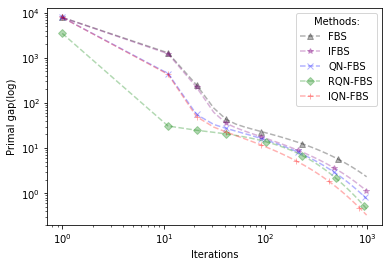

In [75]:
maxnum =int(1000/10) 
x_axis=np.arange(0,1000,10)+1
plt.loglog(x_axis,(np.array(GAP[1:maxnum+1])-GAP[-1]), '^--',markevery=0.1, color='black', alpha=0.3, label='FBS')
plt.loglog(x_axis,(np.array(GAP6[1:maxnum+1])-GAP[-1]), '*--',markevery=0.1, color='purple', alpha=0.3, label='IFBS')
plt.loglog(x_axis,(np.array(GAP5[1:maxnum+1])-GAP[-1]), 'x--',markevery=0.1, color='blue', alpha=0.3, label='QN-FBS')
plt.loglog(x_axis,(np.array(GAP4[1:maxnum+1])-GAP[-1]), 'D--',markevery=0.1, color='green', alpha=0.3, label='RQN-FBS')
plt.loglog(x_axis,(np.array(GAP3[1:maxnum+1])-GAP[-1]), '+--', markevery=0.1,color='red', alpha=0.3, label='IQN-FBS')
plt.xlabel('Iterations')
plt.ylabel('Primal gap(log)')
#plt.title('Convergence')
plt.legend(title='Methods:')
plt.savefig('Image-deblurring.pdf')
plt.show()